In [1]:
abstract type Node end
#@code_warntype, @simd, @inbounds, statyczne typowenie (brak niestabilności typów, brak Any), @benchmark_tools, @btime, brak alokacji, 
#kolumny czy wiersze w for
#test co szybsz, Matrix czy Array{Float64, 2}
#softmax backward

mutable struct Conv2DNode <: Node
    x::Array{Float64, 4}
    W::Array{Float64, 4}
    b::Vector{Float64}
    batch_size::Int
    kernel_size::Tuple{Int, Int}
    filters::Int
    output::Array{Float64, 4}
    gradient_W::Array{Float64, 4}
    gradient_b::Vector{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct MaxPoolNode <: Node
    x::Array{Float64, 4}
    pool_size::Tuple{Int, Int}
    output::Array{Float64, 4}
end

mutable struct DenseNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    W::Matrix{Float64} 
    b::Vector{Float64}
    neurons::Int
    output::Matrix{Float64}
    gradient_W::Matrix{Float64}
    gradient_b::Matrix{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct FlattenNode <: Node
    x::Array{Float64, 4}
    output::Matrix{Float64}
    input_shape::Tuple{Int, Int, Int}
end

mutable struct ReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct SoftmaxNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct SigmoidNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct TanhNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct LeakyReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    alpha::Float64
end


In [2]:
function forward!(node::Conv2DNode, x) 
    node.x = x
    W = node.W
    b = node.b

    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width,  num_chanels, num_filters = size(W)

    output_height = 1 + (input_height - filter_height)
    output_width = 1 + (input_width - filter_width)

    output = zeros(batch_size, output_height, output_width, num_filters)
    for n in 1:batch_size
        for f in 1:num_filters
            for j in 1:input_width-filter_width+1, i in 1:input_height-filter_height+1
                    window = view(x, n, i:i+filter_height-1, j:j+filter_width-1, :)
                    output[n, i, j, f] = sum(window .* W[:,:,:,f]) + b[f]
                    
            end
        end
    end
    
    node.output = output
end

function forward!(node::MaxPoolNode, x)
    node.x = x
    pool_size = node.pool_size
    
    batch_size, input_height, input_width, input_channels = size(x)

    output_height = 1 + (input_height - pool_size[1]) ÷ pool_size[1]
    output_width = 1 + (input_width - pool_size[2]) ÷ pool_size[2]

    output = zeros(batch_size, output_height, output_width, input_channels)

    for n in 1:batch_size
        for c in 1:input_channels
            for j in 1:pool_size[2]:input_width-pool_size[2]+1, i in 1:pool_size[1]:input_height-pool_size[1]+1
                    window = view(x, n, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c)
                    output[n, 1+div(i-1, pool_size[1]), 1+div(j-1, pool_size[2]), c] = maximum(window)
            end
        end
    end

    node.output = output
end


function forward!(node::ReLUNode, x)
    node.x = x
    node.output = max.(0, x)
end

function forward!(node::DenseNode, x)
    node.x = x
    W = node.W
    b = node.b
    node.output = x * W .+ b'
end

function forward!(node::SoftmaxNode, x)
    node.x = x
    exp_x = exp.(x .- maximum(x, dims=2))
    node.output = exp_x ./ sum(exp_x, dims=2)
end

function forward!(node::FlattenNode, x)
    node.x = x
    node.output = reshape(x, size(x, 1), size(x, 2) * size(x, 3) * size(x, 4))
end

function forward!(node::SigmoidNode, x)
    node.x = x
    node.output = 1.0 ./ (1.0 .+ exp.(-x))
end

function forward!(node::TanhNode, x)
    node.x = x
    node.output = tanh.(x)
end

function forward!(node::LeakyReLUNode, x)
    node.x = x
    node.output = ifelse.(x .> 0, x, node.alpha .* x)
end

forward! (generic function with 9 methods)

In [3]:
function backward!(node::Conv2DNode, dy, x)
    W = node.W
    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width, num_channels, num_filters = size(W)

    dx = zeros(size(x))
    dW = zeros(size(W))
    db = zeros(num_filters)

    for n in 1:batch_size
        for f in 1:num_filters
            for j in 1:input_width - filter_width + 1, i in 1:input_height - filter_height + 1
                    dx[n, i:i + filter_height - 1, j:j + filter_width - 1, :] .+= W[:, :, :, f] .* dy[n, i, j, f]
                    dW[:, :, :, f] .+= view(x, n, i:i + filter_height - 1, j:j + filter_width - 1, :) .* dy[n, i, j, f]
            end
            db[f] += sum(dy[n, :, :, f])
        end
    end

    return (dx, dW, db)
end


function backward!(node::MaxPoolNode, dy, x)
    pool_size = node.pool_size
    new_size = size(node.output)
    dy = reshape(dy, new_size)
    
    #println("back_max_pool ",size(dy),size(x), pool_size)
    
    batch_size, height, width, channels = size(x)
    dx = zeros(size(x))
    for b in 1:batch_size
        for c in 1:channels
            for j in 1:pool_size[2]:width-pool_size[2]+1, i in 1:pool_size[1]:height-pool_size[1]+1
                    window = view(x, b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c)
                    dx[b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c] .+= dy[b, i ÷ pool_size[1]+1, j ÷ pool_size[2]+1, c] .* (window .== maximum(window))
            end
        end
    end
    return dx
end


function backward!(node::DenseNode, dy, x)
    W = node.W
    #println("back_dense ",size(dy),size(x), size(W))
    dx, dW, db = dy * W', x' * dy, reshape(sum(dy, dims=1), :, 1)
    #println("back_dense123 ",size(dx),size(dW), size(db))
    return (dx, dW, db)
end


function backward!(node::ReLUNode, dy, x)
    #println("back_relu ", size(dy), size(x))
    dx = dy .* (x .> 0)
    return dx
end

function backward!(node::FlattenNode, dy, x)
    input_shape = node.input_shape
    dx = reshape(dy, size(x, 1), input_shape...)
    return dx
end


function backward!(node::SigmoidNode, dy, x)
    dx = dy .* (node.output .* (1.0 .- node.output))
    return dx
end

function backward!(node::TanhNode, dy, x)
    dx = dy .* (1.0 .- node.output .^ 2)
    return dx
end

function backward!(node::LeakyReLUNode, dy, x)
    dx = dy .* ifelse.(x .> 0, 1, node.alpha)
    return dx
end

backward! (generic function with 8 methods)

In [4]:
function Conv2DNode(; batch_size::Int, filters::Int, kernel_size::Tuple{Int, Int}, input_shape::Tuple{Int, Int, Int}, activation::String)
    W = randn(kernel_size[1], kernel_size[2], input_shape[3], filters) * sqrt(1 / (kernel_size[1] * kernel_size[2] * input_shape[3]))
    b = zeros(filters)

    return Conv2DNode(zeros((input_shape..., batch_size)), W, b, batch_size, kernel_size, filters, zeros((input_shape..., size(W)[4])), zeros((1, 1, 1, 1)), zeros(1), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function MaxPoolNode(; pool_size::Tuple{Int, Int})
    return MaxPoolNode(zeros((1, 1, 1, 1)), pool_size, zeros((1, 1, 1, 1)))
end

function DenseNode(; neurons::Int, activation::String, input_shape::Union{Tuple{Int, Int}, Tuple{Int, Int, Int}})
    W = randn(prod(input_shape), neurons) * sqrt(1 / (prod(input_shape)))
    b = zeros(neurons)

    return DenseNode(zeros((input_shape..., 1, 1)), W, b, neurons, zeros((1,1)), zeros((1, 1)), zeros((1, 1)), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function FlattenNode(; input_shape::Tuple{Int, Int, Int})
    return FlattenNode(zeros((input_shape..., 1)), zeros((1, 1)), input_shape)
end

function ReLUNode()
    return ReLUNode(zeros((1, 1, 1, 1)), zeros((1, 1, 1, 1)))
end

function SoftmaxNode()
    return SoftmaxNode(zeros((1, 1)), zeros((1, 1)))
end

function TanhNode()
    return TanhNode(zeros((1, 1)), zeros((1, 1)))
end

function SigmoidNode()
    return SigmoidNode(zeros((1, 1)), zeros((1, 1)))
end

function LeakyReLUNode(alpha::Float64)
    return LeakyReLUNode(zeros((1, 1)), zeros((1, 1)), alpha)
end


function forward_pass!(graph, x)
    input = x
    for node in graph
        forward!(node, input)
        input = node.output
    end
    return input
end

function backward_pass!(graph, y_true)
    preds = graph[end].output
    dout  = softmax_cross_entropy_backward(preds, y_true)
    
    for i in reverse(1:length(graph)-1)
        layer = graph[i]
        prev_layer_output = i > 1 ? graph[i - 1].output : layer.x
        if hasproperty(layer, :gradient_W)
            dout,dW,db = backward!(layer, dout, prev_layer_output)
            layer.gradient_W = dW
            layer.gradient_b = db

        else 
            dout = backward!(layer, dout, prev_layer_output)
        end
    end
end

function onehotbatch(labels, classes)
    Y = zeros(Int, length(labels), length(classes))
    for (i, label) in enumerate(labels)
        Y[i, label .== classes] .= 1
    end
    return Y
end

function graph_build(layers)
    output = []
    for layer in layers
        push!(output, layer)
        if hasproperty(layer, :activation)
            push!(output, getActivation(layer.activation))
        end
    end

    return output
end

function getActivation(name)
    if name == "relu"
        return ReLUNode()
    elseif name == "softmax"
        return SoftmaxNode()
    elseif name == "sigmoid"
        return SigmoidNode()
    elseif name == "tanh"
        return TanhNode()
    elseif name == "leakyrelu"
        return LeakyReLUNode(0.01)
    else 
        error("no such activation function")
    end
end

function softmax_cross_entropy_backward(y_pred, y_true)
    batch_size = size(y_pred, 1)
    dloss = (y_pred .- onehotbatch(y_true, 0:9)) ./ size(y_true, 1)
    return dloss
end

import Base.hasproperty
hasproperty(x, s::Symbol) = s in fieldnames(typeof(x))

hasproperty (generic function with 1 method)

In [5]:
function update_adam!(layer, learning_rate, t, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8)
    layer.m_W = beta1 * layer.m_W + (1 - beta1) * layer.gradient_W
    layer.v_W = beta2 * layer.v_W + (1 - beta2) * layer.gradient_W .^ 2
    mhat_W = layer.m_W / (1 - beta1 ^ t)
    vhat_W = layer.v_W / (1 - beta2 ^ t)
    layer.W .-= learning_rate .* mhat_W ./ (sqrt.(vhat_W) .+ epsilon)


    layer.m_b = beta1 * layer.m_b + (1 - beta1) * layer.gradient_b
    layer.v_b = beta2 * layer.v_b + (1 - beta2) * layer.gradient_b .^ 2
    mhat_b = layer.m_b / (1 - beta1 ^ t)
    vhat_b = layer.v_b / (1 - beta2 ^ t)
    layer.b .-= learning_rate .* mhat_b ./ (sqrt.(vhat_b) .+ epsilon)
end

function update_sgd!(layer, learning_rate)
    layer.W .-= learning_rate .* layer.gradient_W
    layer.b .-= learning_rate .* layer.gradient_b
end

function train!(graph, train_x, train_y, epochs=5, batch_size=32, learning_rate=1e-3, optimizer="adam")
    total_batches = ceil(Int, size(train_x, 1) / batch_size)
    each = ceil(Int, total_batches/10)
 
    loss_history = zeros(ceil(Int, total_batches*epochs/each))
    counter = 1
    
    for epoch in 1:epochs
        println("----EPOCH $epoch----")

        idx = randperm(size(train_x, 1))
        train_x = train_x[idx, :, :, :]
        train_y = train_y[idx]
        loss = 0
        current_epoch_loss = zeros(total_batches)
        

        for i in 1:batch_size:size(train_x, 1)
            x_batch = train_x[i:min(i+batch_size-1, end), :, :, :]
            y_batch = train_y[i:min(i+batch_size-1, end)]
            tmp  = (i ÷ batch_size)

            forward_pass!(graph, x_batch)
            
            loss = -sum(log.(graph[end].output) .* onehotbatch(y_batch, 0:9))#/size(y_batch, 1)
            current_epoch_loss[tmp+1] = loss
            
            backward_pass!(graph, y_batch)

            for layer in graph
                if hasproperty(layer, :gradient_W)
                    if optimizer == "adam"
                        update_adam!(layer, learning_rate, i)
                    elseif optimizer == "sgd"
                        update_sgd!(layer, learning_rate)
                    else
                        error("Invalid optimizer selected.")
                    end
                end
            end

            
            if i == 1  ||  tmp % each == 0
                avg_loss = sum(current_epoch_loss)/(tmp+1)

                loss_history[counter] = avg_loss
                counter += 1
                print(i ÷ batch_size, "/", total_batches)
                println(" avg epoch loss: ", round(avg_loss, digits=5))
                
            end
        end
        println()
        
    end
    println("Training finished!")

    return loss_history
end

function evaluate(graph, x_data, y_data, batch_size, pool_size)
    num_correct = 0
    num_samples = size(x_data, 1)

    for i in 1:batch_size:num_samples
        x_batch = x_data[i:min(i+batch_size-1, end), :, :, :]
        y_batch = y_data[i:min(i+batch_size-1, end)]
        
        forward_pass!(graph, x_batch)
        pred = graph[end].output
        
        predictions = argmax.(eachrow(pred)) .- 1
        num_correct += sum(predictions .== y_batch)
    end

    accuracy = num_correct / num_samples
    return accuracy
end

function plot_loss(loss::Vector{Float64}, epochs::Int)
    plot(1:size(loss,1), loss, label="loss_batches")

    each = Int64(size(loss,1)/epochs)
    pts = loss[each:each:end]
    plot!(each:each:each*size(pts,1), pts, seriestype=:scatter, label="epochs")
end


plot_loss (generic function with 1 method)

In [6]:
using PyCall
using LinearAlgebra
using Random

mnist = pyimport("mnist")

# Load the MNIST dataset
train_data = mnist.train_images()
train_labels = Int64.(mnist.train_labels())
train_x =  reshape(train_data, :, 28, 28, 1) / 255.0
train_y = train_labels


n = 1000
idx = randperm(n)
train_x = train_x[idx, :,:,:]
train_y = train_y[idx]

train_y[1]

4

----EPOCH 1----
0/63 avg epoch loss: 39.68099
7/63 avg epoch loss: 36.05574
14/63 avg epoch loss: 33.90774
21/63 avg epoch loss: 30.69501
28/63 avg epoch loss: 29.18815
35/63 avg epoch loss: 26.08478
42/63 avg epoch loss: 24.10439
49/63 avg epoch loss: 22.69327
56/63 avg epoch loss: 21.87251

----EPOCH 2----
0/63 avg epoch loss: 16.5116
7/63 avg epoch loss: 10.4552
14/63 avg epoch loss: 9.57447
21/63 avg epoch loss: 9.50623
28/63 avg epoch loss: 9.76479
35/63 avg epoch loss: 9.65156
42/63 avg epoch loss: 9.57589
49/63 avg epoch loss: 9.72558
56/63 avg epoch loss: 9.40044

----EPOCH 3----
0/63 avg epoch loss: 4.47811
7/63 avg epoch loss: 7.0741
14/63 avg epoch loss: 5.96594
21/63 avg epoch loss: 6.15974
28/63 avg epoch loss: 6.3407
35/63 avg epoch loss: 6.33522
42/63 avg epoch loss: 6.30013
49/63 avg epoch loss: 6.24522
56/63 avg epoch loss: 6.11284

Training finished!


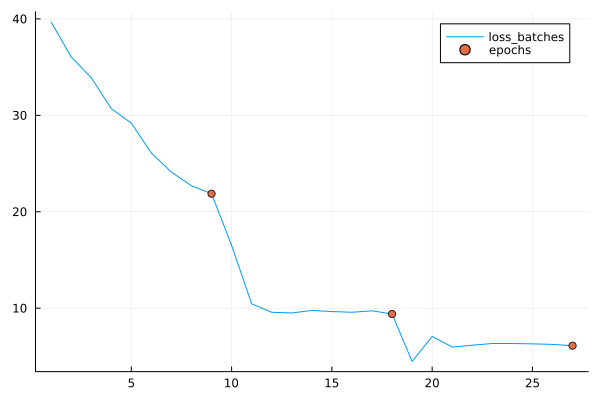

In [13]:
using Plots
#using BenchmarkTools: @btime

epochs = 3
batch_size = 16
learning_rate = 0.0075
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=2, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,2)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,2)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph = graph_build(model)

loss = train!(graph, train_x, train_y, epochs, batch_size, learning_rate, "adam")
plot_loss(loss, epochs)

In [22]:
test_data = mnist.test_images()
test_labels = Int64.(mnist.test_labels())

test_x =  reshape(test_data, :, 28, 28, 1) / 255.0
test_y = test_labels

n = 5000
idx = randperm(n)

test_x = test_x[idx, :,:,:]
test_y = test_y[idx]

accuracy = evaluate(graph, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.8212


----EPOCH 1----
0/16 avg epoch loss: 167.38948
2/16 avg epoch loss: 157.14773
4/16 avg epoch loss: 154.58339
6/16 avg epoch loss: 149.96334
8/16 avg epoch loss: 145.67213
10/16 avg epoch loss: 141.41149
12/16 avg epoch loss: 137.43503
14/16 avg epoch loss: 132.00282

----EPOCH 2----
0/16 avg epoch loss: 83.3737
2/16 avg epoch loss: 88.08394
4/16 avg epoch loss: 83.72199
6/16 avg epoch loss: 79.17688
8/16 avg epoch loss: 76.06024
10/16 avg epoch loss: 72.83292
12/16 avg epoch loss: 71.4785
14/16 avg epoch loss: 68.83259

----EPOCH 3----
0/16 avg epoch loss: 57.0956
2/16 avg epoch loss: 47.6644
4/16 avg epoch loss: 47.85129
6/16 avg epoch loss: 47.33534
8/16 avg epoch loss: 45.51791
10/16 avg epoch loss: 45.64605
12/16 avg epoch loss: 45.08582
14/16 avg epoch loss: 45.27988

----EPOCH 4----
0/16 avg epoch loss: 27.86498
2/16 avg epoch loss: 38.62776
4/16 avg epoch loss: 36.1864
6/16 avg epoch loss: 37.58715
8/16 avg epoch loss: 36.28799
10/16 avg epoch loss: 36.43501
12/16 avg epoch loss

12/16 avg epoch loss: 7.87093
14/16 avg epoch loss: 7.76802

----EPOCH 3----
0/16 avg epoch loss: 5.84873
2/16 avg epoch loss: 6.94297
4/16 avg epoch loss: 7.94108
6/16 avg epoch loss: 7.37064
8/16 avg epoch loss: 7.15515
10/16 avg epoch loss: 7.65775
12/16 avg epoch loss: 7.16575
14/16 avg epoch loss: 7.06177

----EPOCH 4----
0/16 avg epoch loss: 8.80341
2/16 avg epoch loss: 7.11852
4/16 avg epoch loss: 6.92754
6/16 avg epoch loss: 6.60787
8/16 avg epoch loss: 6.38252
10/16 avg epoch loss: 6.07635
12/16 avg epoch loss: 6.04186
14/16 avg epoch loss: 6.75714

----EPOCH 5----
0/16 avg epoch loss: 4.14553
2/16 avg epoch loss: 3.97268
4/16 avg epoch loss: 5.64073
6/16 avg epoch loss: 6.90453
8/16 avg epoch loss: 6.492
10/16 avg epoch loss: 6.51576
12/16 avg epoch loss: 6.82229
14/16 avg epoch loss: 6.61012

----EPOCH 6----
0/16 avg epoch loss: 4.76356
2/16 avg epoch loss: 4.83716
4/16 avg epoch loss: 5.54727
6/16 avg epoch loss: 5.68131
8/16 avg epoch loss: 5.69115
10/16 avg epoch loss: 5.

4/16 avg epoch loss: 2.69665
6/16 avg epoch loss: 2.39245
8/16 avg epoch loss: 2.39937
10/16 avg epoch loss: 2.33444
12/16 avg epoch loss: 2.19163
14/16 avg epoch loss: 2.20405

----EPOCH 6----
0/16 avg epoch loss: 1.41819
2/16 avg epoch loss: 1.90404
4/16 avg epoch loss: 2.53215
6/16 avg epoch loss: 2.44395
8/16 avg epoch loss: 2.42938
10/16 avg epoch loss: 2.22314
12/16 avg epoch loss: 2.17911
14/16 avg epoch loss: 2.22157

----EPOCH 7----
0/16 avg epoch loss: 1.69329
2/16 avg epoch loss: 2.47988
4/16 avg epoch loss: 2.19031
6/16 avg epoch loss: 2.22817
8/16 avg epoch loss: 2.28681
10/16 avg epoch loss: 2.10902
12/16 avg epoch loss: 1.96417
14/16 avg epoch loss: 2.02813

----EPOCH 8----
0/16 avg epoch loss: 0.91606
2/16 avg epoch loss: 1.17986
4/16 avg epoch loss: 1.67277
6/16 avg epoch loss: 2.05598
8/16 avg epoch loss: 1.8561
10/16 avg epoch loss: 1.87498
12/16 avg epoch loss: 1.94502
14/16 avg epoch loss: 1.91709

----EPOCH 9----
0/16 avg epoch loss: 2.54403
2/16 avg epoch loss: 2

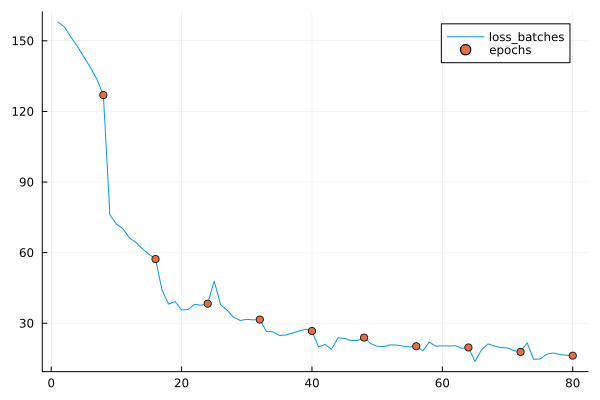

In [23]:
using Plots

epochs = 10
batch_size = 64
learning_rate = 0.0025
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=32, filters=2, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,2)),
    DenseNode(neurons=32, activation="relu", input_shape=(72, 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph = graph_build(model)

loss = train!(graph, train_x, train_y, epochs, batch_size, learning_rate, "adam")
plot_loss(loss, epochs)

In [24]:
accuracy = evaluate(graph, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.851
